In [1]:
pip install pydicom

In [2]:
import pydicom as dicom
import zipfile
from io import StringIO
from PIL import Image
import imghdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [72]:
# specify your image path
#read train images 
dir_name = r"/content/drive/MyDrive/stage_2_train_images.zip"

zippedImgs = zipfile.ZipFile(dir_name)
df_dicom_data_train = pd.DataFrame(columns = ['Pixel Data','Patient Name','patientId','Patient Sex','Patient Age',
                                             'Body Part Examined','View Position'])


for i in range(len(zippedImgs.namelist())):
    
    file_in_zip = zippedImgs.namelist()[i]
    if (".dcm" in file_in_zip or ".DCM" in file_in_zip):
        
        with zippedImgs.open(file_in_zip) as f:
          ds = dicom.dcmread(f)
          print(ds.pixel_array)
          df_dicom_data_train = df_dicom_data_train.append({'Pixel Data':ds.pixel_array,'Patient Name':ds.PatientName ,'Patient ID':ds.PatientID,
                                                            'Patient Sex':ds.PatientSex,'Patient Age':ds.PatientAge,
                                                            'Body Part Examined':ds.BodyPartExamined  ,'View Position':ds.ViewPosition},ignore_index=True)
          
    else:
        print("Not Found")
    break


[[144 128 114 ... 176 184 117]
 [125 109  95 ... 171 178 111]
 [104  89  75 ... 166 175 108]
 ...
 [ 16  14  11 ...  19  15   3]
 [ 18  16  12 ...  21  17   5]
 [ 19  17  13 ...  23  19   6]]


In [25]:
#Store training data in json
df_dicom_data_train.to_csv(r"/content/drive/MyDrive/stage_2_train_images.csv",index=None)


In [70]:
from numpy import loadtxt
x = pd.read_csv(r"/content/drive/MyDrive/stage_2_train_images.csv")
#x['Pixel Data'] = x['Pixel Data'].to_numpy()
x = pd.read_csv(r"/content/drive/MyDrive/stage_2_train_images.csv",converters = 
                {'Pixel Data':lambda x: x.split('\n')} )
#x['Pixel Data'] = x['Pixel Data'].apply(lambda x : str(x).replace('\'',''))
#x['Pixel Data'] = x['Pixel Data'].apply(lambda x : x.replace('\'[',''))

x['Pixel Data'] = x['Pixel Data'].to_numpy()
#x['Pixel Data'] = x['Pixel Data'].apply(lambda x : x.replace('[','').replace(']','').split('\n'))
#x['Pixel Data'] = x['Pixel Data'].apply(lambda x :[i.split() for i in x])
#x['Pixel Data'] = x['Pixel Data'].apply(lambda x :np.array(x, int) )
#x['Pixel Data'] = x['Pixel Data'].to_numpy()
x['Pixel Data'][0]

['[[144 128 114 ... 176 184 117]',
 ' [125 109  95 ... 171 178 111]',
 ' [104  89  75 ... 166 175 108]',
 ' ...',
 ' [ 16  14  11 ...  19  15   3]',
 ' [ 18  16  12 ...  21  17   5]',
 ' [ 19  17  13 ...  23  19   6]]']

In [ ]:
# specify your image path
#read test images 
dir_name = r"/content/drive/MyDrive/stage_2_test_images.zip"

zippedImgs = zipfile.ZipFile(dir_name)
df_dicom_data_train = pd.DataFrame(columns = ['Pixel Data','Patient Name','Patient ID','Patient Sex','Patient Age',
                                             'Body Part Examined','View Position'])


for i in range(len(zippedImgs.namelist())):
    
    file_in_zip = zippedImgs.namelist()[i]
    if (".dcm" in file_in_zip or ".DCM" in file_in_zip):
        
        with zippedImgs.open(file_in_zip) as f:
          ds = dicom.dcmread(f)
          df_dicom_data_train = df_dicom_data_train.append({'Pixel Data':ds.pixel_array,'Patient Name':ds.PatientName ,'Patient ID':ds.PatientID,
                                                            'Patient Sex':ds.PatientSex,'Patient Age':ds.PatientAge,
                                                            'Body Part Examined':ds.BodyPartExamined  ,'View Position':ds.ViewPosition},ignore_index=True)
          #plt.imshow(ds.pixel_array)

    else:
        print("Not Found")
    

In [ ]:
#Store testing data in csv
df_dicom_data_train.to_csv(r"/content/drive/MyDrive/stage_2_test_images.json")

In [5]:
#Read class info
dir_name = r"/content/drive/MyDrive/stage_2_detailed_class_info.csv"

df_class_info = pd.read_csv(dir_name)
df_class_info.head(5)

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [6]:
#Read train labels 
dir_name = r"/content/drive/MyDrive/stage_2_train_labels.csv"

df_train_labels = pd.read_csv(dir_name)
df_train_labels.head(5)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [7]:
print('Training Label Shape &','Class Info Shape',df_train_labels.shape,df_class_info.shape)

Training Label Shape & Class Info Shape (30227, 6) (30227, 2)


In [8]:
#Find count of patient ids common in training labels and class info
len(pd.Series(df_train_labels.patientId.isin(df_class_info.patientId).values.astype(int), df_train_labels.patientId.values))

30227

In [9]:
#Find count of patient ids common in training labels and class info
len(pd.Series(df_class_info.patientId.isin(df_train_labels.patientId).values.astype(int), df_class_info.patientId.values))

30227

In [10]:
ctab1 = pd.crosstab(df_class_info.patientId,df_class_info['class'])
ctab1

class,Lung Opacity,No Lung Opacity / Not Normal,Normal
patientId,,,
0004cfab-14fd-4e49-80ba-63a80b6bddd6,0,1,0
000924cf-0f8d-42bd-9158-1af53881a557,0,0,1
000db696-cf54-4385-b10b-6b16fbb3f985,2,0,0
000fe35a-2649-43d4-b027-e67796d412e0,2,0,0
001031d9-f904-4a23-b3e5-2c088acd19c6,2,0,0
...,...,...,...
fffb2395-8edd-4954-8a89-ffe2fd329be3,2,0,0
fffba05a-1635-4545-9bbd-57ad4cfe8d27,0,0,1
fffc95b5-605b-4226-80ab-62caec682b22,0,1,0


In [11]:

#Create new column to indicate if any patient has multi class entries
ctab1['Multiple_Class'] = ctab1.apply(lambda row: True if ((row['Lung Opacity'] > 0 and row['No Lung Opacity / Not Normal'] > 0) or 
                                                           (row['Normal'] > 0 and row['No Lung Opacity / Not Normal'] > 0) or 
                                                           (row['Normal'] > 0 and row['Lung Opacity'] > 0)) else False,axis=1)


ctab1[ctab1['Multiple_Class']==True]

#No multi class entry present for any patient

class,Lung Opacity,No Lung Opacity / Not Normal,Normal,Multiple_Class
patientId,,,,


In [12]:
ctab2 = pd.crosstab(df_train_labels.patientId,df_train_labels['Target'])
ctab2


Target,0,1
patientId,,
0004cfab-14fd-4e49-80ba-63a80b6bddd6,1,0
000924cf-0f8d-42bd-9158-1af53881a557,1,0
000db696-cf54-4385-b10b-6b16fbb3f985,0,2
000fe35a-2649-43d4-b027-e67796d412e0,0,2
001031d9-f904-4a23-b3e5-2c088acd19c6,0,2
...,...,...
fffb2395-8edd-4954-8a89-ffe2fd329be3,0,2
fffba05a-1635-4545-9bbd-57ad4cfe8d27,1,0
fffc95b5-605b-4226-80ab-62caec682b22,1,0


In [13]:
ctab2

Target,0,1
patientId,,
0004cfab-14fd-4e49-80ba-63a80b6bddd6,1,0
000924cf-0f8d-42bd-9158-1af53881a557,1,0
000db696-cf54-4385-b10b-6b16fbb3f985,0,2
000fe35a-2649-43d4-b027-e67796d412e0,0,2
001031d9-f904-4a23-b3e5-2c088acd19c6,0,2
...,...,...
fffb2395-8edd-4954-8a89-ffe2fd329be3,0,2
fffba05a-1635-4545-9bbd-57ad4cfe8d27,1,0
fffc95b5-605b-4226-80ab-62caec682b22,1,0


In [14]:

#Create new column to indicate if any patient has multiple values for target
ctab2['Multiple_Target'] = ctab2.apply(lambda row: True if (row[0] > 0 and row[1] > 0) else False,axis=1)


ctab2[ctab2['Multiple_Target']==True]

#No multi target entry present for any patient

Target,0,1,Multiple_Target
patientId,,,


In [16]:
df_train_labels_class = pd.merge(df_train_labels , df_class_info,on='patientId' )


In [20]:
df_train_labels_class

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity
...,...,...,...,...,...,...,...
37624,c1f6b555-2eb1-4231-98f6-50a963976431,NaN,NaN,NaN,NaN,0,Normal
37625,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1,Lung Opacity
37626,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1,Lung Opacity
37627,c1f7889a-9ea9-4acb-b64c-b737c929599a,233.0,424.0,201.0,356.0,1,Lung Opacity


In [22]:
df_train_labels_class[df_train_labels_class['Target']==1]['class'].value_counts()
#Only class 'Lung Opacity' has target value as 1

Lung Opacity    16957
Name: class, dtype: int64

In [26]:
#Read dicom data from csv file
df_dicom_data_train = pd.read_csv(r"/content/drive/MyDrive/stage_2_train_images.json")


In [27]:
df_dicom_data_train.head(5)

,Unnamed: 0,Pixel Data,Patient Name,patientId,Patient Sex,Patient Age,Body Part Examined,View Position
0,0,[[144 128 114 ... 176 184 117]\n [125 109 95 ...,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0004cfab-14fd-4e49-80ba-63a80b6bddd6,F,51,CHEST,PA
1,1,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,000924cf-0f8d-42bd-9158-1af53881a557,000924cf-0f8d-42bd-9158-1af53881a557,F,19,CHEST,AP
2,2,[[ 1 1 2 ... 2 1 0]\n [ 2 2 2 ...,000db696-cf54-4385-b10b-6b16fbb3f985,000db696-cf54-4385-b10b-6b16fbb3f985,F,25,CHEST,AP
3,3,[[ 1 10 9 ... 2 0 0]\n [10 18 18 ... 1 0...,000fe35a-2649-43d4-b027-e67796d412e0,000fe35a-2649-43d4-b027-e67796d412e0,M,40,CHEST,AP
4,4,[[ 0 0 0 ... 14 14 13]\n [ 0 0 0 ... 23 22...,001031d9-f904-4a23-b3e5-2c088acd19c6,001031d9-f904-4a23-b3e5-2c088acd19c6,M,57,CHEST,PA


In [28]:
#Merge dicom data with labels and class data

df_data = pd.merge(df_dicom_data_train,df_train_labels_class,on='patientId')

In [39]:
df_data['View Position'].value_counts()

AP    21817
PA    15812
Name: View Position, dtype: int64

In [40]:
df_data['Body Part Examined'].value_counts()

CHEST    37629
Name: Body Part Examined, dtype: int64

In [29]:
df_data.head(5)

,Unnamed: 0,Pixel Data,Patient Name,patientId,Patient Sex,Patient Age,Body Part Examined,View Position,x,y,width,height,Target,class
0,0,[[144 128 114 ... 176 184 117]\n [125 109 95 ...,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0004cfab-14fd-4e49-80ba-63a80b6bddd6,F,51,CHEST,PA,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,1,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,000924cf-0f8d-42bd-9158-1af53881a557,000924cf-0f8d-42bd-9158-1af53881a557,F,19,CHEST,AP,NaN,NaN,NaN,NaN,0,Normal
2,2,[[ 1 1 2 ... 2 1 0]\n [ 2 2 2 ...,000db696-cf54-4385-b10b-6b16fbb3f985,000db696-cf54-4385-b10b-6b16fbb3f985,F,25,CHEST,AP,316.0,318.0,170.0,478.0,1,Lung Opacity
3,2,[[ 1 1 2 ... 2 1 0]\n [ 2 2 2 ...,000db696-cf54-4385-b10b-6b16fbb3f985,000db696-cf54-4385-b10b-6b16fbb3f985,F,25,CHEST,AP,316.0,318.0,170.0,478.0,1,Lung Opacity
4,2,[[ 1 1 2 ... 2 1 0]\n [ 2 2 2 ...,000db696-cf54-4385-b10b-6b16fbb3f985,000db696-cf54-4385-b10b-6b16fbb3f985,F,25,CHEST,AP,660.0,375.0,146.0,402.0,1,Lung Opacity


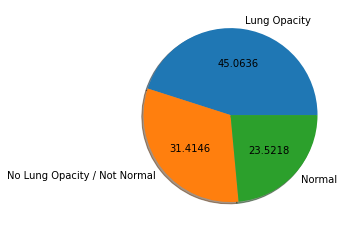

In [36]:
#Get class distribution
v_counts = df_data['class'].value_counts()
plt.pie(v_counts, labels=v_counts.index, autopct='%.4f', shadow=True);
plt.show()

#Data is fairly balanced with 45% pneumonia cases and 55% non-pneumonia cases

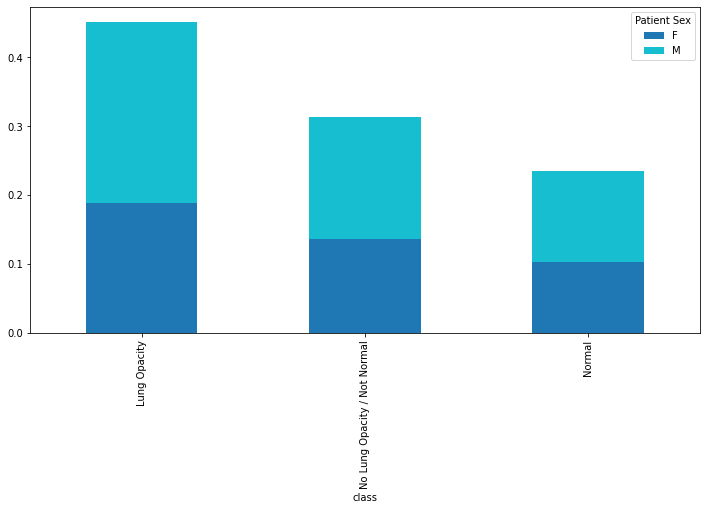

In [37]:
cross_tab = pd.crosstab(index=df_data['class'],
                        columns=df_data['Patient Sex'],normalize=True)
cross_tab.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(12, 6))
plt.show()
#All class seem to have slightly higher male distribution compared to females

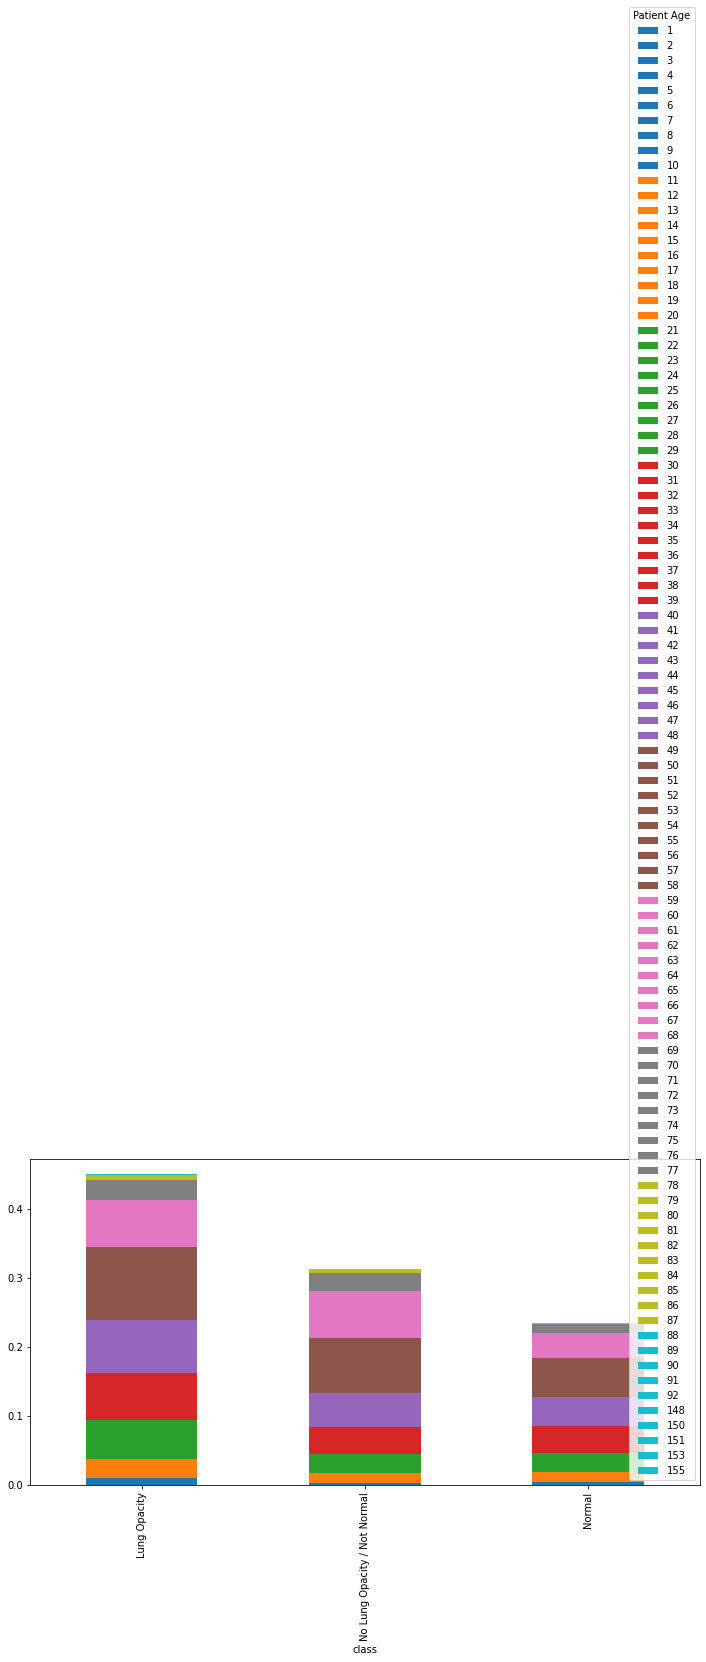

In [38]:
cross_tab = pd.crosstab(index=df_data['class'],
                        columns=df_data['Patient Age'],normalize=True)
cross_tab.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(12, 6))
plt.show()

#The age range 21-68 years seem to be most susceptible to pneumonia 

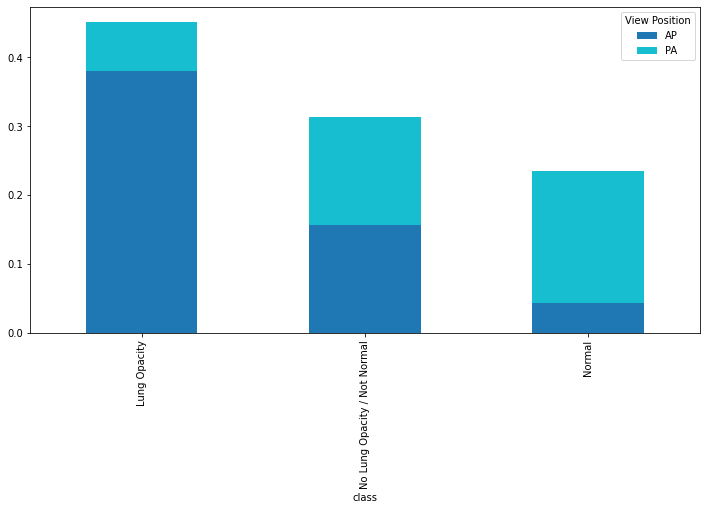

In [41]:
cross_tab = pd.crosstab(index=df_data['class'],
                        columns=df_data['View Position'],normalize=True)
cross_tab.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(12, 6))
plt.show()
#AP orientation seem to account for ~90% of pneumonia cases

In [46]:
df_data['Pixel Data'][0]

'[[144 128 114 ... 176 184 117]\n [125 109  95 ... 171 178 111]\n [104  89  75 ... 166 175 108]\n ...\n [ 16  14  11 ...  19  15   3]\n [ 18  16  12 ...  21  17   5]\n [ 19  17  13 ...  23  19   6]]'